Adversarial Attacks on Deep Neural Networks

Importing the required libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy import newaxis

Loading the dataset

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Defining the model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(10)
])
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_function,metrics=['accuracy'])

Training the model

In [ ]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2153 - accuracy: 0.9368
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0877 - accuracy: 0.9733
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0590 - accuracy: 0.9817
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0415 - accuracy: 0.9866
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0314 - accuracy: 0.9898


Testing the model

In [ ]:
res = model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0693 - accuracy: 0.9787 - 515ms/epoch - 2ms/step


Function to check correct classifications

In [ ]:
def find_correct_classification(model, X, Y):
  correctly_classified_images = []
  correctly_classified_labels = []
  count = 0

  for i, img in enumerate(X):
    img = img[newaxis, ...]
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    if pred == Y[i]:
      count+=1
      correctly_classified_images.append(tf.convert_to_tensor(img, dtype=tf.float32))
      correctly_classified_labels.append(tf.convert_to_tensor(Y[i]))
  return count, correctly_classified_images, correctly_classified_labels

Function to generate perturbed images

In [ ]:
def generate_perturb_untargeted_image(model, X, Y, epsilon_target):
  X = tf.convert_to_tensor(X, dtype=tf.float32)
  x_perturb = []

  x_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(X)
    pred = model(X)
    loss = loss_function(Y, pred)
  grad = tape.gradient(loss, X)
  grad_sign = tf.sign(grad)
  x_perturb.append(tf.clip_by_value((X + epsilon_target * grad_sign), clip_value_min = 0, clip_value_max = 1))

  return x_perturb

Function to calculate perturbation classification accuracy

In [ ]:
def generate_perturb_untargeted_correct_image(model, X, Y, epsilon_target):
  x_perturb = []
  for i, img in enumerate(X):
    img = tf.convert_to_tensor(img, dtype=tf.float32)

    x_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(img)
      pred = model(img)
      loss = loss_function(Y[i], pred)
    grad = tape.gradient(loss, img)
    grad_sign = tf.sign(grad)
    x_perturb.append(tf.clip_by_value((img + epsilon_target * grad_sign), clip_value_min = 0, clip_value_max = 1))
  return x_perturb

Function to calculate perturbation classification accuracy

In [ ]:
def calculate_perturb_classification_accuracy(model, perturbImg, Y):
  pred = model.predict(perturbImg)
  pred = tf.nn.softmax(pred)
  pred = tf.math.argmax(pred, axis=1).numpy()
  res = model.evaluate(perturbImg,  Y, verbose=2)
  return res, pred

Function to calculate perturbation correct classification accuracy

In [ ]:
def calculate_perturb_correct_classification_accuracy(model, perturbImg, Y):
  count = 0
  pred_label = []
  for i, img in enumerate(perturbImg):
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    if pred == Y[i]:
      pred_label.append(pred)
      count+=1
  return count/len(Y), pred_label

Function to generate perturbed target correct images

In [ ]:
def generate_perturb_targeted_image(model, X, Y, epsilon):
  y_test_modify = []
  for i in Y:
    y_test_modify.append((i+1)%10)
  x_perturb = []
  x_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(x_tensor)
    pred = model(x_tensor)
    loss = loss_function(y_test_modify, pred)
  grad = tape.gradient(loss, x_tensor)
  grad_sign = tf.sign(grad)
  x_perturb.append(tf.clip_by_value((x_tensor - epsilon * grad_sign), clip_value_min = 0, clip_value_max = 1))

  return x_perturb

Function to generate perturbed target correct image

In [ ]:
def generate_perturb_targeted_correct_image(model, X, Y, epsilon_target):
  y_test_modify = []
  for i in Y:
    y_test_modify.append((i+1)%10)

  x_perturb = []
  for i, img in enumerate(X):
    x_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(x_tensor)
      pred = model(x_tensor)
      loss = loss_function(y_test_modify[i], pred)
    grad = tape.gradient(loss, x_tensor)
    grad_sign = tf.sign(grad)
    x_perturb.append(tf.clip_by_value((x_tensor - epsilon_target * grad_sign), clip_value_min = 0, clip_value_max = 1))

  return x_perturb

Function to calculate perturbation correct target classification accuracy

In [ ]:
def calculate_perturb_correct_classification_target_accuracy(model, perturbImg, Y):
  count = 0
  pred_label = []
  for i, img in enumerate(perturbImg):
    pred = model(img)
    pred = tf.nn.softmax(pred)
    pred = tf.math.argmax(pred, axis=1).numpy()
    pred_label.append(pred)

    if pred[0] == (Y[i]+1).numpy():
      pred_label.append(pred)
      count+=1
  return count/len(Y), pred_label

In [ ]:
def display_images(images,epi,title):
    plt.figure(figsize=(15, 3))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f'Epsilon: {epi}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

Untargeted Attack

313/313 [==============================] - 0s 1ms/step
313/313 - 0s - loss: 0.0892 - accuracy: 0.9722 - 498ms/epoch - 2ms/step


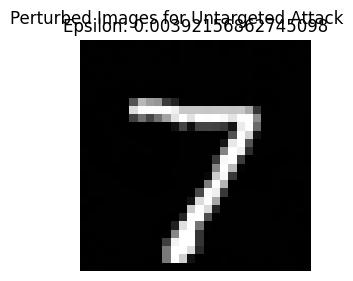

313/313 [==============================] - 0s 1ms/step
313/313 - 0s - loss: 0.2262 - accuracy: 0.9331 - 431ms/epoch - 1ms/step


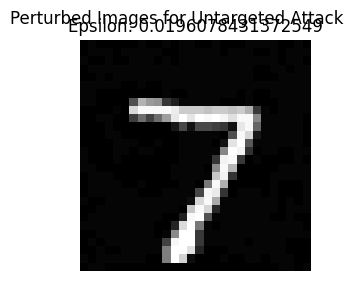

313/313 [==============================] - 0s 1ms/step
313/313 - 0s - loss: 0.6579 - accuracy: 0.8083 - 421ms/epoch - 1ms/step


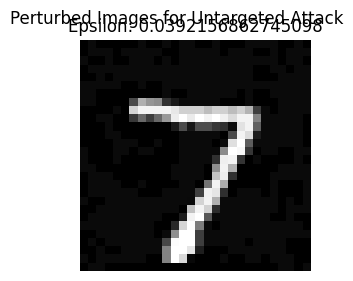

313/313 [==============================] - 1s 2ms/step
313/313 - 0s - loss: 3.0920 - accuracy: 0.3359 - 421ms/epoch - 1ms/step


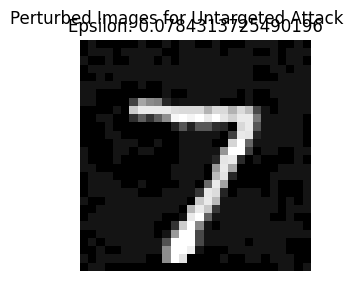

313/313 [==============================] - 0s 1ms/step
313/313 - 0s - loss: 6.6251 - accuracy: 0.1176 - 404ms/epoch - 1ms/step


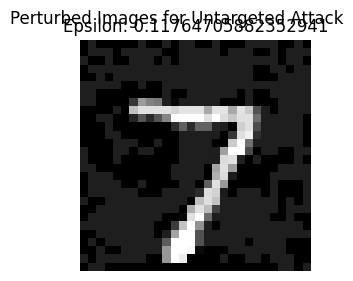

313/313 [==============================] - 0s 1ms/step
313/313 - 0s - loss: 9.9985 - accuracy: 0.0562 - 415ms/epoch - 1ms/step


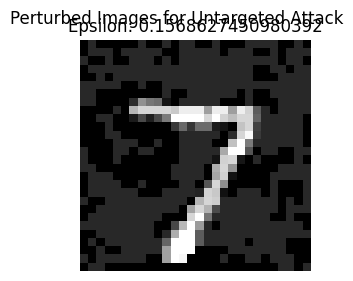

313/313 [==============================] - 0s 1ms/step
313/313 - 0s - loss: 13.1604 - accuracy: 0.0309 - 417ms/epoch - 1ms/step


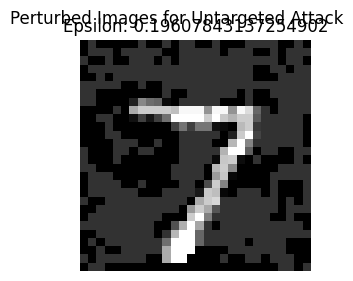

In [ ]:
epsilon_values = [1/255, 5/255, 10/255, 20/255, 30/255, 40/255, 50/255]
accuracy_untargeted = []
success_rate_untargeted_attack = []
nocc, correctly_classified_images, correctly_classified_labels = find_correct_classification(model, x_test, y_test)
for eps in epsilon_values:
  x_perturb = generate_perturb_untargeted_image(model, x_test, y_test, eps)
  acc, y_pred = calculate_perturb_classification_accuracy(model, x_perturb, y_test)
  accuracy_untargeted.append(acc[1])

  display_images(x_perturb, eps, 'Perturbed Images for Untargeted Attack')
  x_perturb_correct_classified = generate_perturb_untargeted_correct_image(model, correctly_classified_images, correctly_classified_labels, eps)
  accuracy_perturb_classified, y_correct_pred = calculate_perturb_correct_classification_accuracy(model, x_perturb_correct_classified, correctly_classified_labels)
  success_rate_untargeted_attack.append(1-accuracy_perturb_classified)

Untargeted attack
epsilon:0.00392156862745098, success rate: 0.006641463165423467
epsilon:0.0196078431372549, success rate: 0.046592418514355805
epsilon:0.0392156862745098, success rate: 0.17410851129048743
epsilon:0.0784313725490196, success rate: 0.6567896188821907
epsilon:0.11764705882352941, success rate: 0.8798406048840298
epsilon:0.1568627450980392, success rate: 0.9425768877081844
epsilon:0.19607843137254902, success rate: 0.9684275058751405


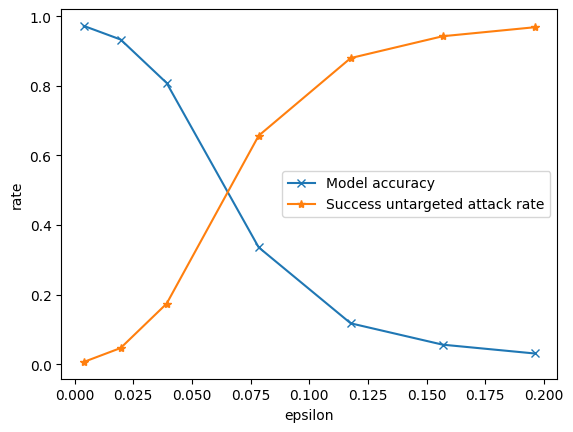

In [ ]:
plt.plot(epsilon_values,accuracy_untargeted,marker='x')
plt.plot(epsilon_values,success_rate_untargeted_attack,marker='*')
plt.xlabel('epsilon')
plt.ylabel('rate')
plt.legend(['Model accuracy','Success untargeted attack rate'])

print("Untargeted attack")
for i, eps in enumerate(epsilon_values):
  print("epsilon:{}, success rate: {}".format(eps, success_rate_untargeted_attack[i]))

Targeted Attack

313/313 [==============================] - 1s 2ms/step
313/313 - 1s - loss: 0.0696 - accuracy: 0.9773 - 558ms/epoch - 2ms/step


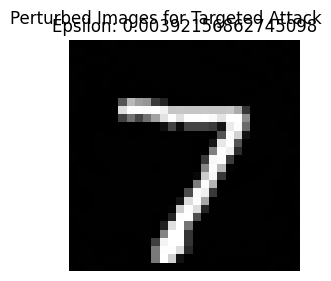

313/313 [==============================] - 0s 1ms/step
313/313 - 0s - loss: 0.0928 - accuracy: 0.9672 - 408ms/epoch - 1ms/step


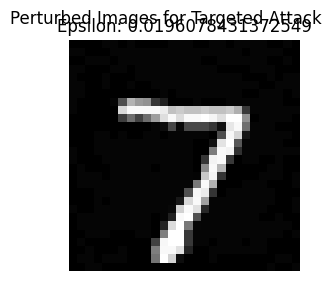

313/313 [==============================] - 0s 1ms/step
313/313 - 0s - loss: 0.2277 - accuracy: 0.9196 - 427ms/epoch - 1ms/step


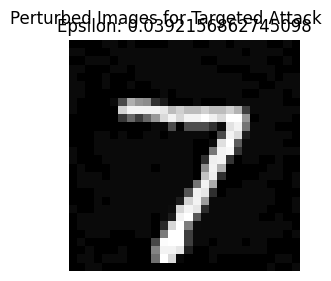

313/313 [==============================] - 0s 1ms/step
313/313 - 1s - loss: 1.5137 - accuracy: 0.5901 - 563ms/epoch - 2ms/step


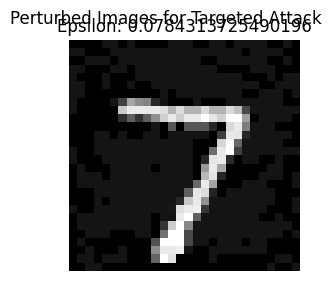

313/313 [==============================] - 0s 1ms/step
313/313 - 0s - loss: 4.2823 - accuracy: 0.2574 - 413ms/epoch - 1ms/step


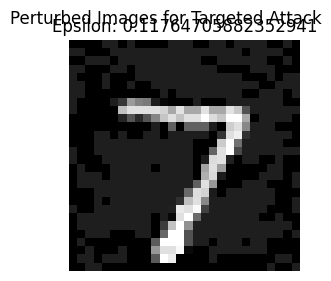

313/313 [==============================] - 0s 1ms/step
313/313 - 0s - loss: 7.4250 - accuracy: 0.1098 - 406ms/epoch - 1ms/step


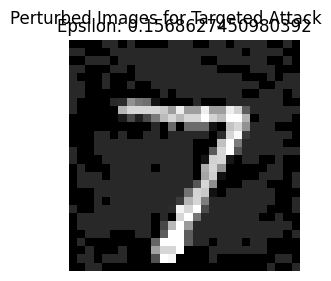

313/313 [==============================] - 0s 1ms/step
313/313 - 1s - loss: 10.5219 - accuracy: 0.0450 - 553ms/epoch - 2ms/step


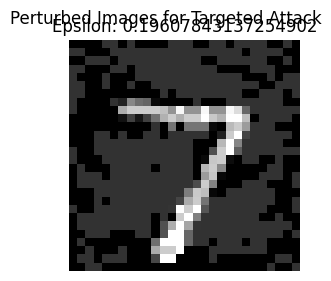

In [ ]:
accuracy_targeted = []
success_rate_targeted_attack = []

epsilon_values = [1/255, 5/255, 10/255, 20/255, 30/255, 40/255, 50/255]
nocct, correctly_classified_target_images, correctly_classified_target_labels = find_correct_classification(model, x_test, y_test)
for eps in epsilon_values:
  x_perturb_tar = generate_perturb_targeted_image(model, x_test, y_test, eps)
  acc_tar, y_pred_tar = calculate_perturb_classification_accuracy(model, x_perturb_tar, y_test)
  accuracy_targeted.append(acc_tar[1])

  display_images(x_perturb_tar, eps, 'Perturbed Images for Targeted Attack')

  x_perturb_correct_tar_classified = generate_perturb_targeted_correct_image(model, correctly_classified_target_images, correctly_classified_target_labels, eps)
  acc_perturb_tar_classified, y_correct_tar_pred = calculate_perturb_correct_classification_target_accuracy(model, x_perturb_correct_tar_classified, correctly_classified_target_labels)
  success_rate_targeted_attack.append(acc_perturb_tar_classified)

Targeted Attack
epsilon: 0.00392156862745098, success rate: 0.00020435271278226218
epsilon: 0.0196078431372549, success rate: 0.003473996117298457
epsilon: 0.0392156862745098, success rate: 0.02155921119852866
epsilon: 0.0784313725490196, success rate: 0.20322877286195976
epsilon: 0.11764705882352941, success rate: 0.4304689894758353
epsilon: 0.1568627450980392, success rate: 0.5687135996730357
epsilon: 0.19607843137254902, success rate: 0.6499438030039849


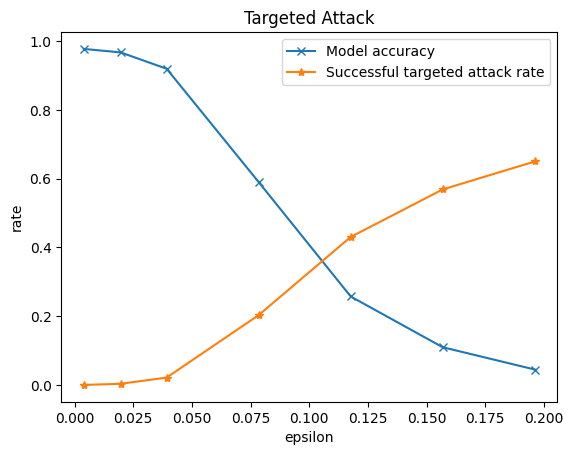

In [ ]:
plt.plot(epsilon_values,accuracy_targeted,marker='x')
plt.plot(epsilon_values,success_rate_targeted_attack,marker='*')
plt.xlabel('epsilon')
plt.ylabel('rate')
plt.legend(['Model accuracy','Successful targeted attack rate'])
plt.title("Targeted Attack")

print("Targeted Attack")
for i, eps in enumerate(epsilon_values):
  print("epsilon: {}, success rate: {}".format(eps, success_rate_targeted_attack[i]))

Untargeted Attack with epsilon = 125/255

In [ ]:
epsilon = 125/255
perturbed_images_retrain = generate_perturb_untargeted_image(model, x_train, y_train, epsilon)
labels_retrain = np.hstack((y_train, y_train))
images_retrain = []
for re in perturbed_images_retrain:
  images_retrain = np.vstack((x_train, re))

Retraining the model

In [ ]:
model_retrain = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(10)
])

model_retrain.compile(optimizer='adam', loss=loss_function,metrics=['accuracy'])

In [ ]:
model_retrain.fit(images_retrain, labels_retrain, epochs=5)

Epoch 1/5
3750/3750 [==============================] - 12s 3ms/step - loss: 0.1310 - accuracy: 0.9625
Epoch 2/5
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0500 - accuracy: 0.9845
Epoch 3/5
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0347 - accuracy: 0.9893
Epoch 4/5
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0255 - accuracy: 0.9921
Epoch 5/5
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0201 - accuracy: 0.9936


In [ ]:
evaluation_result_retrain = model_retrain.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0664 - accuracy: 0.9814 - 904ms/epoch - 3ms/step


In [ ]:
nocc, correctly_classified_images, correctly_classified_labels = find_correct_classification(model, x_test, y_test)
x_perturb = generate_perturb_untargeted_image(model_retrain, x_test, y_test, epsilon)
accuracy_retrain, y_pred_retrain = calculate_perturb_classification_accuracy(model_retrain, x_perturb, y_test)

x_perturb_correct_classified = generate_perturb_untargeted_correct_image(model_retrain, correctly_classified_images, correctly_classified_labels, epsilon)
accuracy_perturb_classified, y_correct_pred = calculate_perturb_correct_classification_accuracy(model_retrain, x_perturb_correct_classified, correctly_classified_labels)

313/313 [==============================] - 0s 1ms/step
313/313 - 1s - loss: 61.1892 - accuracy: 0.0000e+00 - 502ms/epoch - 2ms/step


In [ ]:
print("Successful attack rate : {}".format((1-accuracy_perturb_classified)))

Successful attack rate : 1.0


No, the adversarially retrained DNN is susceptible to untargetted FSGM attacks.